<a href="https://colab.research.google.com/github/akshitadixit/Retinopathy/blob/main/loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import csv
import pandas as pd
from google.colab import drive
drive.mount("/content/gdrive")

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,Conv2D,Dropout,Dense,Activation, MaxPooling2D, Flatten

Mounted at /content/gdrive


In [ ]:
data_root = "/content/gdrive/My Drive/Colab Notebooks/dataset"
path = os.path.join(data_root, "symp")

with open('/content/gdrive/My Drive/Colab Notebooks/dataset/dataset.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  for i in os.listdir(path):
    writer.writerow([0, os.path.join(path, i)])

In [ ]:
path = os.path.join(data_root, "nosymp")

with open('/content/gdrive/My Drive/Colab Notebooks/dataset/dataset.csv', 'a', newline='') as file:
  writer = csv.writer(file)
  for i in os.listdir(path):
    writer.writerow([1, os.path.join(path, i)])

In [ ]:
# shuffle the data in csv
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dataset/dataset.csv')
ds = df.sample(frac=1)
ds.to_csv('/content/gdrive/My Drive/Colab Notebooks/dataset/dataset.csv', index=False)

In [ ]:
##############

In [ ]:
!pip install split-folders

In [10]:
# split the data

import numpy as np
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/dataset_aux/dataset.csv', header=None)
df.columns = ["class", "path"]
df = df.astype({"class": str})
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.7*len(df)), int(.85*len(df))])

In [11]:
len(train["path"])

978

In [19]:
# Model parameters
BATCH_SIZE = 10
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 500
WIDTH = 500
CANAL = 3
N_CLASSES = 2
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [20]:
train_idg = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_idg = ImageDataGenerator(rescale=1./255)

train_generator = train_idg.flow_from_dataframe(dataframe=train,
                                                      directory=None,
                                                      x_col="path",
                                                      y_col="class",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH))

valid_generator = train_idg.flow_from_dataframe(dataframe=validate,
                                                      directory=None,
                                                      x_col="path",
                                                      y_col="class",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH))

test_generator = test_idg.flow_from_dataframe(dataframe=test,
                                                      directory=None,
                                                      x_col="path",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    


Found 978 validated image filenames belonging to 2 classes.
Found 210 validated image filenames belonging to 2 classes.
Found 210 validated image filenames.


In [21]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(500,500,3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
97/97 [==============================] - 187s 2s/step - loss: 1.8776 - accuracy: 0.6061 - val_loss: 0.5762 - val_accuracy: 0.7476
Epoch 2/2
97/97 [==============================] - 135s 1s/step - loss: 0.5681 - accuracy: 0.7426 - val_loss: 0.5775 - val_accuracy: 0.7476


In [23]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)

In [24]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
97/97 [==============================] - 136s 1s/step - loss: 0.5801 - accuracy: 0.7242 - val_loss: 0.5427 - val_accuracy: 0.7524
Epoch 2/20
97/97 [==============================] - 136s 1s/step - loss: 0.5546 - accuracy: 0.7417 - val_loss: 0.5341 - val_accuracy: 0.7571
Epoch 3/20
97/97 [==============================] - 137s 1s/step - loss: 0.5605 - accuracy: 0.7490 - val_loss: 0.5352 - val_accuracy: 0.7524
Epoch 4/20
97/97 [==============================] - 136s 1s/step - loss: 0.5478 - accuracy: 0.7459 - val_loss: 0.5393 - val_accuracy: 0.7524
Epoch 5/20
97/97 [==============================] - 135s 1s/step - loss: 0.5416 - accuracy: 0.7469 - val_loss: 0.5396 - val_accuracy: 0.7571

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
97/97 [==============================] - 136s 1s/step - loss: 0.5070 - accuracy: 0.7521 - val_loss: 0.5125 - val_accuracy: 0.7524
Epoch 7/20
97/97 [==============================] - 135s 1s/step - loss: 

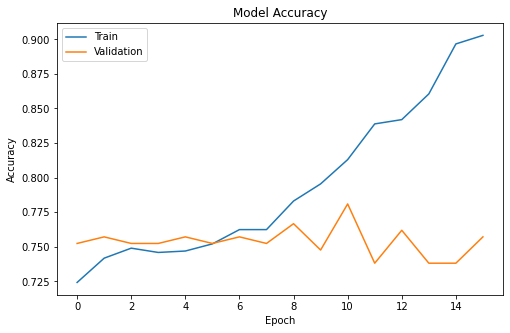

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()